In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

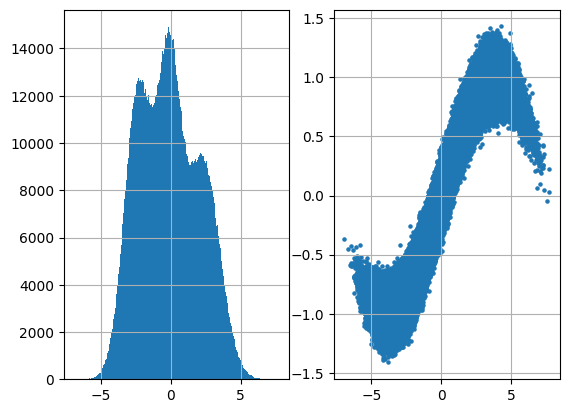

In [2]:
np.random.seed(1234)
x=np.concat([np.random.normal(-2.3,1,500000),np.random.normal(-0.1,0.8,400000),np.random.normal(2.3,1.2,450000)])
y=np.sin(0.4*x)+np.random.normal(0,0.1,1350000)
df=pd.DataFrame({'x':x,'y':y})

fig,ax=plt.subplots(1,2)
ax[0].hist(df['x'],bins='auto')
ax[1].scatter(x,y,s=5)
ax[0].grid()
ax[1].grid()

# Discretización

In [4]:
df['x'].min(),df['x'].max()

(-6.922794121873831, 7.719224281699823)

In [5]:
lims=np.linspace(df['x'].min(),df['x'].max(),4)
lims

array([-6.92279412, -2.04212132,  2.83855148,  7.71922428])

In [6]:
# Definimos tres centroides de forma aleatoria
bins=3
ctr=[np.random.uniform(lims[i-1],lims[i]) for i in range(1,bins+1)]
ctr

[-5.186670890449618, -0.17152905254558326, 6.97095124529736]

In [ ]:
df['x'][0] # Primer observación

np.float64(-1.8285648362675069)

In [ ]:
# Encontramos a qué centroide está más cerca la primer observación
np.abs(ctr-df['x'][0]).argmin()

np.int64(1)

In [ ]:
# Saludos
diferencia=[]
for c_i in ctr:
  diferencia.append(np.abs(c_i-df['x']).values.reshape(-1,1))
diferencia[0].shape

(1350000, 1)

In [ ]:
diferencias=np.concatenate(diferencia,axis=1)
diferencias.shape

(1350000, 3)

In [ ]:
grupos=diferencias.argmin(axis=1)
df['grupos']=grupos
df.head()

,x,y,grupos
0,-1.828565,-0.746743,1
1,-3.490976,-0.857561,0
2,-0.867293,-0.122020,1
3,-2.612652,-0.808089,1
4,-3.020589,-0.997937,0


In [ ]:
ctr_anteroir=ctr.copy() # Para evitar llamados a referencia

In [ ]:
# Calculamos los nuevos centroides
ctr=df.groupby('grupos')['x'].mean().values
ctr

array([-3.35300679,  0.10089599,  4.05033773])

In [ ]:
np.linalg.norm(ctr_anteroir-np.array(ctr))

np.float64(3.459266214822579)

In [ ]:
eps=1e-5

```python
# Definir una función que, dada la variable a discretizar, regrese el arreglo de grupos al que pertenece cada observación
def kmens(x,bins):
  lims=np.linspace(x.min(),x.max(),bins+1)
  ctr=[np.random.uniform(lims[i-1],lims[i]) for i in range(1,bins+1)]
  diferencia=[]
  for c_i in ctr:
    diferencia.append(np.abs(c_i-x).values.reshape(-1,1))
  diferencias=np.concatenate(diferencia,axis=1)
  grupos=diferencias.argmin(axis=1)
  ctr_anteroir=ctr.copy()
  ctr=df.groupby('grupos')['x'].mean().values
  return grupos
  ```

In [ ]:
def kmens(x,bins):
  lims=np.linspace(x.min(),x.max(),bins+1)
  ctr=np.array([np.random.uniform(lims[i-1],lims[i]) for i in range(1,bins+1)])

  while True:
    diferencia=[]

    for c_i in ctr:
      diferencia.append(np.abs(c_i-x).values.reshape(-1,1))

    diferencias=np.concatenate(diferencia,axis=1)
    grupos=diferencias.argmin(axis=1)

    dff = pd.DataFrame({'x': x, 'grupos': grupos})

    ctr_anteroir=ctr.copy()
    ctr=df.groupby('grupos')['x'].mean().values

    if np.linalg.norm(ctr_anteroir-ctr)<eps:
      break
  return grupos , ctr

grupos, ctr = kmens(df['x'], 3)
df['grupos'] = grupos
display(ctr)
df.head()




array([-2.49315797,  0.02437403,  2.7320792 ])

,x,y,grupos
0,-1.828565,-0.746743,0
1,-3.490976,-0.857561,0
2,-0.867293,-0.122020,1
3,-2.612652,-0.808089,0
4,-3.020589,-0.997937,0


,x
grupos,
0,"Axes(0.125,0.11;0.775x0.77)"
1,"Axes(0.125,0.11;0.775x0.77)"
2,"Axes(0.125,0.11;0.775x0.77)"


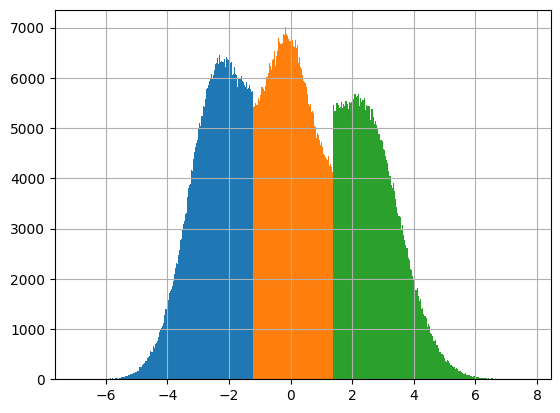

In [ ]:
df.groupby('grupos')['x'].hist(bins='auto')

### Usando SKLearn

In [7]:
from sklearn.preprocessing import KBinsDiscretizer

In [8]:
discretizador=KBinsDiscretizer(n_bins=3,encode='ordinal',strategy='kmeans') # strategy='uniform' -> ancho constante.
                                                                            #          'quantile' -> frecuencia constante
df['grupos']=discretizador.fit_transform(df[['x']])
df.head()

,x,y,grupos
0,-1.828565,-0.746743,0.0
1,-3.490976,-0.857561,0.0
2,-0.867293,-0.122020,1.0
3,-2.612652,-0.808089,0.0
4,-3.020589,-0.997937,0.0


In [9]:
df.groupby('grupos')['x'].mean()

,x
grupos,
0.0,-2.502966
1.0,-0.002018
2.0,2.706641


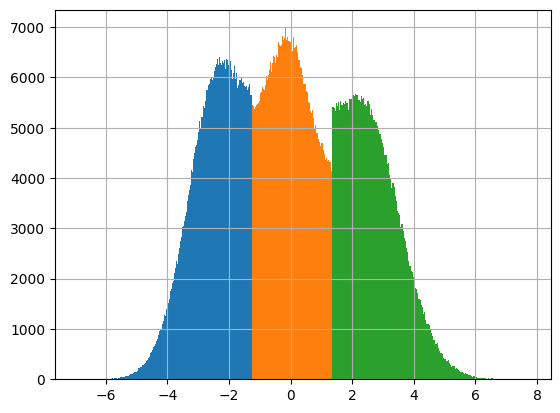

In [10]:
H=df.groupby('grupos')['x'].hist(bins='auto')

# Regresión lineal usando los centroides

In [11]:
x=df.groupby('grupos')[['x']].mean().values # shape=(3,1)
y=df.groupby('grupos')['y'].mean().values   # shape=(3,)

In [12]:
lin=LinearRegression()        # Para la regresión lineal de los datos sin discretizar
lin_kmeans=LinearRegression() # Para los datos discretizados con kmeans
lin_f=LinearRegression()      # Para los datos discretizados con frecuencia constante

In [15]:
df['freq']=pd.qcut(df['x'],3)
x_f=df.groupby('freq')[['x']].mean().values
y_f=df.groupby('freq')['y'].mean().values

<ipython-input-15-c390a6ba20d5>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_f=df.groupby('freq')[['x']].mean().values
<ipython-input-15-c390a6ba20d5>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y_f=df.groupby('freq')['y'].mean().values


In [16]:
# Entrenación
lin.fit(df[['x']],df['y']) # Datos sin discretizar
lin_kmeans.fit(x,y)        # Datos discretizados con kmeans
lin_f.fit(x_f,y_f)         # Datos discretizados con frecuencia constante

LinearRegression()

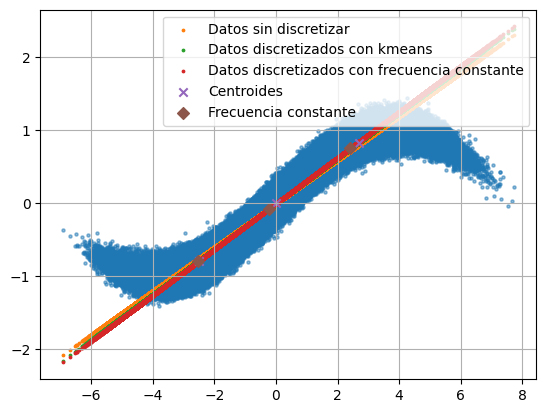

In [19]:
plt.scatter(df['x'],df['y'],s=5,alpha=0.5)
plt.scatter(df['x'],lin.predict(df[['x']]),label='Datos sin discretizar',s=3)

plt.scatter(df['x'],lin_kmeans.predict(df[['x']].values),label='Datos discretizados con kmeans',s=3)

plt.scatter(df['x'],lin_f.predict(df[['x']].values),label='Datos discretizados con frecuencia constante',s=3)

plt.scatter(x,y,label='Centroides',marker='x')
plt.scatter(x_f,y_f,label='Frecuencia constante',marker='D')
plt.legend(loc=1)
plt.grid()

In [20]:
lin.coef_[0],lin_kmeans.coef_[0],lin_f.coef_[0]

(np.float64(0.2995051972597301),
 np.float64(0.3109442133954521),
 np.float64(0.3146037659563825))

# Regresión lineal para cada conjunto de datos

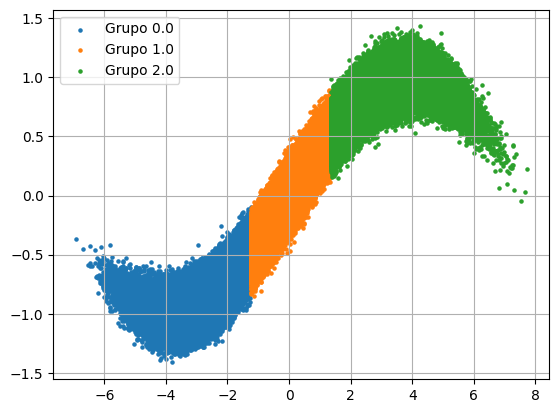

In [25]:
for c_i in df['grupos'].unique():
  x=df[df['grupos']==c_i]['x']
  y=df[df['grupos']==c_i]['y']
  # x=df.groupby('grupos').get_group(c_i)
  # idx_x=df.groupby('grupos').groups[c_i]
  plt.scatter(x,y,s=5,label=f'Grupo {c_i}')
plt.legend(loc='upper left')
plt.grid()

In [22]:
# Entrenamientes
lin={}
for c_i in df['grupos'].unique():
  lin[c_i]=LinearRegression()
  x=df[df['grupos']==c_i]['x']
  y=df[df['grupos']==c_i]['y']
  lin[c_i].fit(x.values.reshape(-1,1),y)

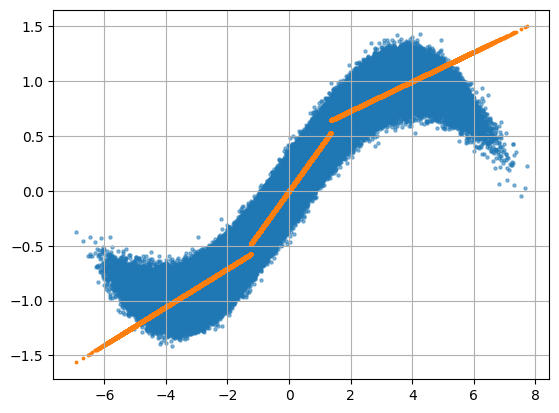

In [32]:
# Predicción
#
# prediccion = f[c_i](x)
def f(obs):
  return lin[obs['grupos']].coef_*obs['x']+lin[obs['grupos']].intercept_

prediccion = df.apply(f,axis=1)
plt.scatter(df['x'],df['y'],s=5,alpha=0.5)
plt.scatter(df['x'],prediccion,s=3)
plt.grid()